<a href="https://colab.research.google.com/github/K28Ayra/Lavit_Seg/blob/main/Lavit_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

!git clone https://github.com/K28Ayra/lavit-seg.git

Cloning into 'lavit-seg'...
fatal: could not read Username for 'https://github.com': No such device or address


In [20]:
from google.colab import files
uploaded = files.upload()


Saving my_dataset.zip to my_dataset.zip


In [21]:
!unzip my_dataset.zip
!ls my_dataset


Archive:  my_dataset.zip
   creating: my_dataset/
   creating: my_dataset/masks/
  inflating: my_dataset/masks/104_mask.png  
  inflating: my_dataset/masks/1054_mask.png  
  inflating: my_dataset/masks/113_mask.png  
  inflating: my_dataset/masks/1849_mask.png  
  inflating: my_dataset/masks/1934_mask.png  
  inflating: my_dataset/masks/1945_mask.png  
  inflating: my_dataset/masks/2129_mask.png  
  inflating: my_dataset/masks/2262_mask.png  
  inflating: my_dataset/masks/2495_mask.png  
  inflating: my_dataset/masks/2647_mask.png  
  inflating: my_dataset/masks/2667_mask.png  
  inflating: my_dataset/masks/2730_mask.png  
  inflating: my_dataset/masks/3280_mask.png  
  inflating: my_dataset/masks/343_mask.png  
  inflating: my_dataset/masks/3452_mask.png  
  inflating: my_dataset/masks/3530_mask.png  
  inflating: my_dataset/masks/3573_mask.png  
  inflating: my_dataset/masks/3594_mask.png  
  inflating: my_dataset/masks/3602_mask.png  
  inflating: my_dataset/masks/388_mask.png  
  i

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [23]:
CONFIG = {
    "image_size": 128,
    "embed_dim": 64,
    "num_heads": 4,
    "depth": 4,
    "reduction_ratio": 4,
    "num_classes": 2,
    "batch_size": 2,
    "epochs": 20
}


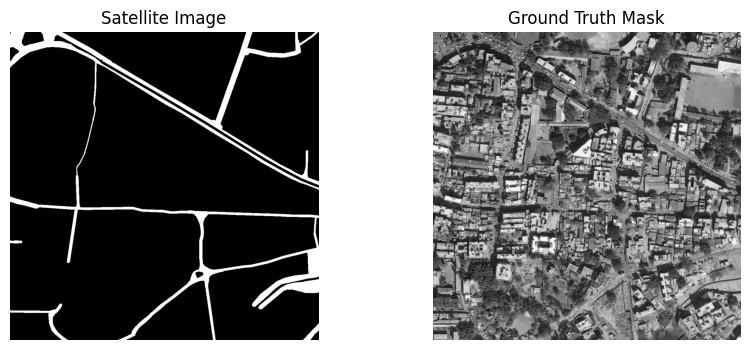

In [28]:
img_path = "my_dataset/masks/1945_mask.png"
mask_path = "my_dataset/train/1945_sat.jpg"

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Satellite Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()


In [29]:
def load_pair(img_path, mask_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (CONFIG["image_size"], CONFIG["image_size"]))
    img = img / 255.0

    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (CONFIG["image_size"], CONFIG["image_size"]),
                      interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.int32)  # binary

    return img.astype(np.float32), mask


In [30]:
def create_dataset(img_dir, mask_dir):
    imgs = sorted(os.listdir(img_dir))
    masks = sorted(os.listdir(mask_dir))

    def gen():
        for i, m in zip(imgs, masks):
            yield load_pair(
                os.path.join(img_dir, i),
                os.path.join(mask_dir, m)
            )
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((CONFIG["image_size"], CONFIG["image_size"], 3), tf.float32),
            tf.TensorSpec((CONFIG["image_size"], CONFIG["image_size"]), tf.int32)
        )
    )
    return ds.batch(CONFIG["batch_size"])


In [46]:
class PatchEmbedding(layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.conv = layers.Conv2D(
            embed_dim,
            kernel_size=7,
            strides=2,
            padding="same"
        )
        self.norm = layers.BatchNormalization()

    def call(self, x):
        x = self.conv(x)
        x = self.norm(x)
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]

        return tf.reshape(x, [B, H * W, C]), (H, W)


In [32]:
class TokenReducer(layers.Layer):
    def __init__(self, r):
        super().__init__()
        self.r = r

    def call(self, x):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        N_r = N // self.r
        x = x[:, :N_r*self.r, :]
        x = tf.reshape(x, [B, N_r, self.r, C])
        return tf.reduce_mean(x, axis=2)


In [33]:
class LAViTBlock(layers.Layer):
    def __init__(self, d, h, r):
        super().__init__()
        self.red = TokenReducer(r)
        self.attn = layers.MultiHeadAttention(h, d//h)
        self.exp = layers.Dense(d)
        self.mlp = models.Sequential([
            layers.Dense(d*4, activation="gelu"),
            layers.Dense(d)
        ])

    def call(self, x):
        N = tf.shape(x)[1]
        y = self.red(x)
        y = self.exp(self.attn(y, y))
        y = tf.repeat(y, N // tf.shape(y)[1], axis=1)
        return x + self.mlp(x + y)


In [34]:
class LAViTSeg(models.Model):
    def __init__(self):
        super().__init__()
        self.patch = PatchEmbedding(CONFIG["embed_dim"])
        self.blocks = [LAViTBlock(CONFIG["embed_dim"],
                                  CONFIG["num_heads"],
                                  CONFIG["reduction_ratio"])
                       for _ in range(CONFIG["depth"])]
        self.conv1 = layers.Conv2D(CONFIG["embed_dim"], 3, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(CONFIG["num_classes"], 1)

    def call(self, x):
        t, (H, W) = self.patch(x)
        for b in self.blocks:
            t = b(t)
        t = tf.reshape(t, [-1, H, W, CONFIG["embed_dim"]])
        t = self.conv1(t)
        return tf.image.resize(self.conv2(t),
                               (CONFIG["image_size"], CONFIG["image_size"]))


In [49]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, CONFIG["num_classes"])
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2])

    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return 1 - tf.reduce_mean(dice)
def focal_loss(y_true, y_pred, gamma=2.0):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, CONFIG["num_classes"])
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    ce = -y_true * tf.math.log(y_pred + 1e-6)
    weight = tf.pow(1 - y_pred, gamma)
    return tf.reduce_mean(weight * ce)
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)


In [56]:
def pixel_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))


In [57]:
def mean_iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    intersection = tf.reduce_sum(
        tf.cast((y_true == 1) & (y_pred == 1), tf.float32)
    )
    union = tf.reduce_sum(
        tf.cast((y_true == 1) | (y_pred == 1), tf.float32)
    )
    return intersection / (union + 1e-6)


In [58]:
model = LAViTSeg()
dummy = tf.random.normal(
    (1, CONFIG["image_size"], CONFIG["image_size"], 3)
)
_ = model(dummy)
model.summary()


Model: "la_vi_t_seg_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding_5               │ ?                      │         9,728 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ la_vi_t_block_20 (LAViTBlock)   │ ?                      │        53,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ la_vi_t_block_21 (LAViTBlock)   │ ?                      │        53,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ la_vi_t_block_22 (LAViTBlock)   │ ?                      │        53,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ la_vi_t_block_23 (LAViTBlock)   │ ?                      │        53,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (1, 64, 64, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (1, 64, 64, 2)         │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,338 (1.00 MB)

 Trainable params: 262,210 (1.00 MB)

 Non-trainable params: 128 (512.00 B)

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[pixel_accuracy, mean_iou])


In [60]:
CONFIG["epochs"] = 50


In [61]:
history = model.fit(
    dataset,
    epochs=CONFIG["epochs"])


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.6018 - mean_iou: 0.0023 - pixel_accuracy: 0.9596
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.5334 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - loss: 0.5312 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.5307 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.5299 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.5292 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.5286 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.5278 - mean_iou: 0.0000e+00 - pixel_accuracy: 0.9654
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.5268 - mean_iou: 0.0000e+00 - pixel_accu

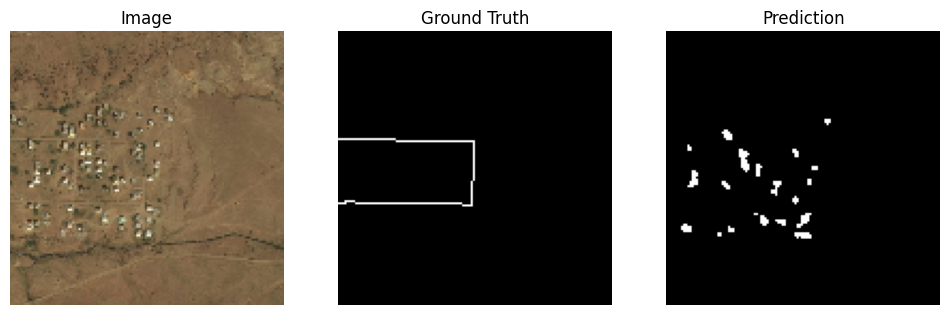

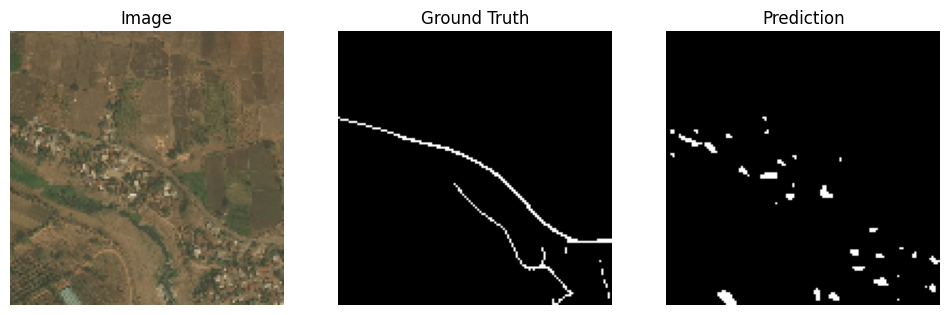

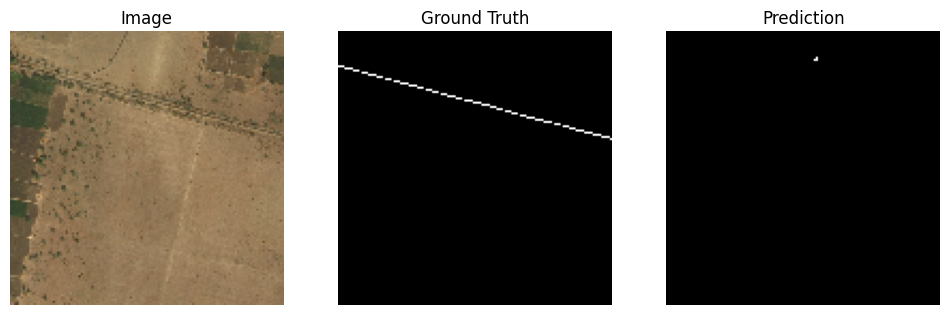

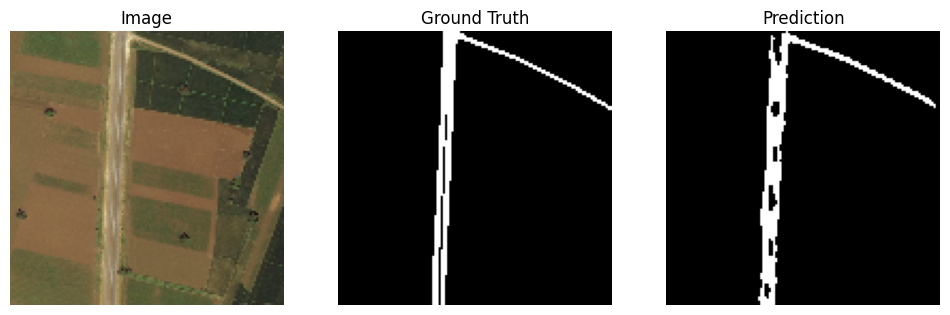

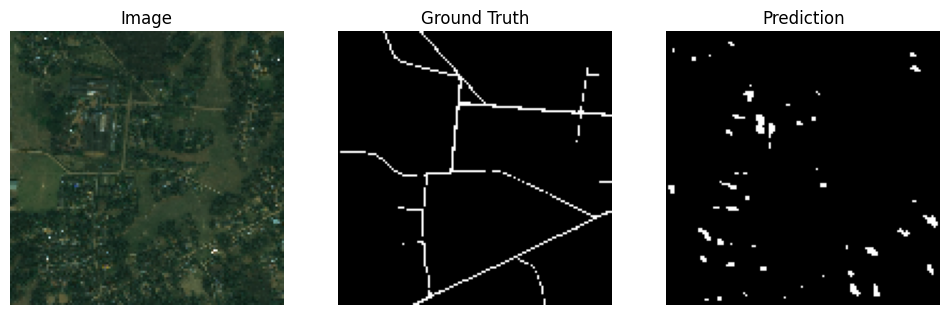

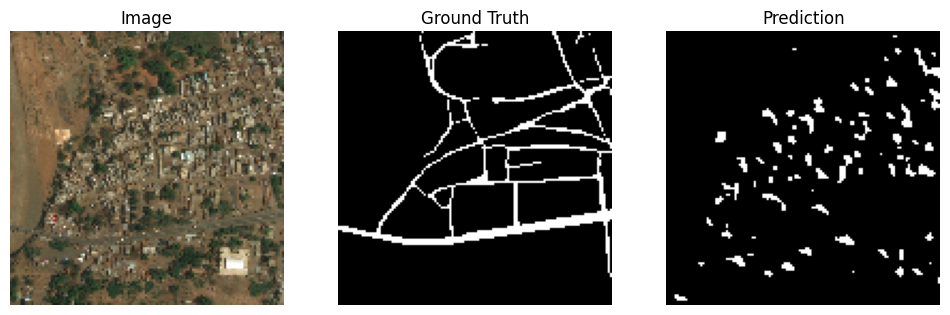

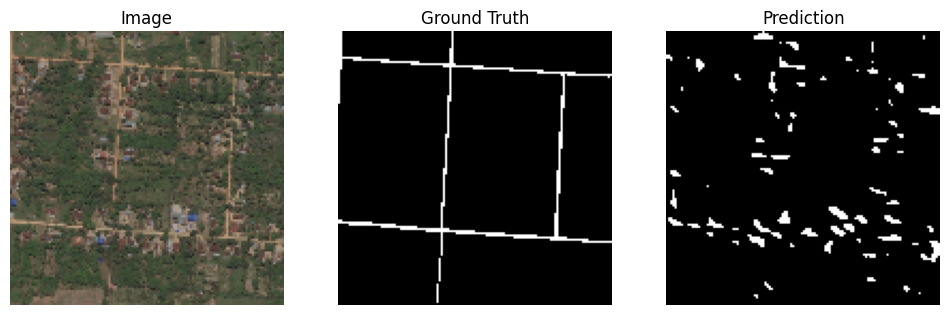

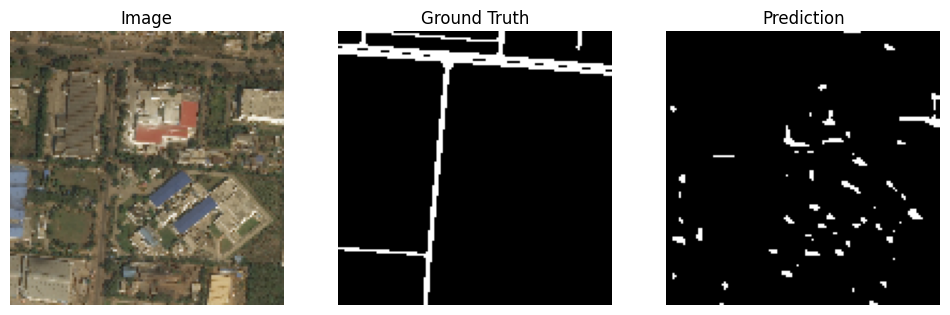

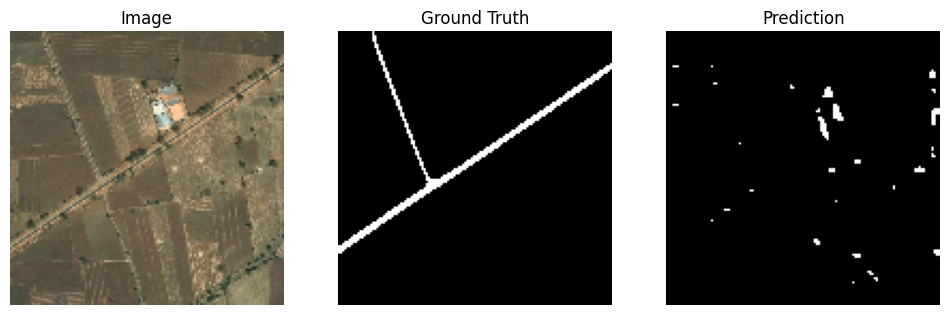

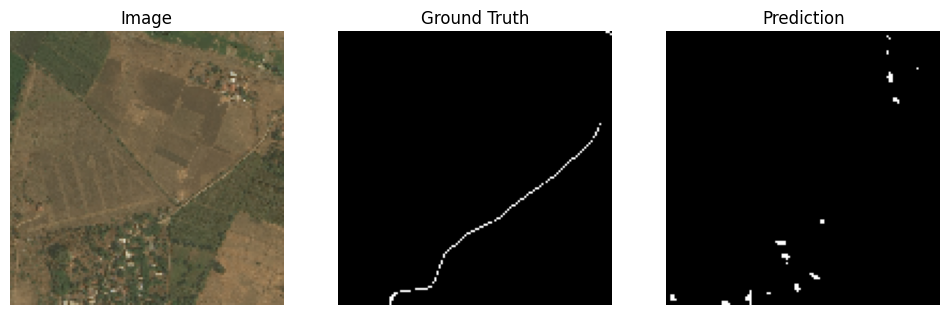

In [63]:
for imgs, masks in dataset.take(10):
    preds = model(imgs)
    preds = tf.argmax(preds, axis=-1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(imgs[0])
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(masks[0], cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(preds[0], cmap="gray")
    plt.axis("off")
    plt.show()
